# Atticus Soane 

# 2016 Election/Census Analysis

The goal of this project is to use 2016 county election data and 2015 sub-county census data to generate a predictive model of voter behavior at the county level. The data used will be 'election.csv', a file containing total votes by county for each candidate in the 2016 presidential race, and 'census.csv', sub-county census data from each county in the United States. 

# Data Prepartion

In the cells below, I will prepare to generate a predictive model of county-level voter behavior by manipulating the data until I have created a single dataframe which aggregates the subcounty census data to county level data and appends the presidential candidate that won each county.

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import sqlite3 as sql


In [2]:
#create SQLite database 
conn = sql.connect('Election.db')
c = conn.cursor()

#create table 
c.execute(''' CREATE TABLE IF NOT EXISTS Election_Raw(county VARCHAR (25), fips VARCHAR (5), candidate VARCHAR (30),
state CHAR (2), votes INTEGER)''')

#fill table with values from csv
read_election = pd.read_csv(r'/Users/atticussoane/Desktop/data/election/election.csv')
read_election.to_sql('Election_Raw', conn, if_exists = 'append', index = False)


#create pandas dataframe from SQL table 
SQL_query = pd.read_sql_query('''SELECT * FROM Election_Raw''', conn)
df1 = DataFrame(SQL_query, columns = ['county', 'fips', 'candidate', 'state', 'votes'])
df1.head()

df1.to_sql('Election_Raw', conn, if_exists = 'append', index = False)

df1.head()

,county,fips,candidate,state,votes
0,None,US,Donald Trump,US,62984825
1,None,US,Hillary Clinton,US,65853516
2,None,US,Gary Johnson,US,4489221
3,None,US,Jill Stein,US,1429596
4,None,US,Evan McMullin,US,510002


Now that the raw election data has been uploaded, I will separate into three separate categories: a national summary of total votes per candidate, a state level summary of total votes per candidate, and a county level summary of total votes per candidate. 

In [3]:
#Create SQL table to store national level election summary data (total votes per candidate nationwide)
c.execute(''' CREATE TABLE IF NOT EXISTS Election_Federal(county VARCHAR (25), fips VARCHAR (5), candidate VARCHAR (30),
state CHAR (2), votes INTEGER)''')

#create pandas dataframe for national level election summary data
SQL_Query2 = pd.read_sql_query('''SELECT DISTINCT * FROM Election_Raw WHERE fips = 'US' ''', conn)

df_federal = DataFrame(SQL_Query2, columns = ['county', 'fips', 'candidate', 'state', 'votes'])

df_federal.to_sql('Election_Federal', conn, if_exists = 'append', index = False)

print(df_federal)

   county fips                  candidate state     votes
0    None   US               Donald Trump    US  62984825
1    None   US            Hillary Clinton    US  65853516
2    None   US               Gary Johnson    US   4489221
3    None   US                 Jill Stein    US   1429596
4    None   US              Evan McMullin    US    510002
5    None   US             Darrell Castle    US    186545
6    None   US             Gloria La Riva    US     74117
7    None   US         Rocky De La Fuente    US     33010
8    None   US   None of these candidates    US     28863
9    None   US             Richard Duncan    US     24235
10   None   US                  Dan Vacek    US     13537
11   None   US             Alyson Kennedy    US     12465
12   None   US                 Mike Smith    US      9095
13   None   US             Chris Keniston    US      6909
14   None   US                  Lynn Kahn    US      5637
15   None   US                 Jim Hedges    US      5609
16   None   US

In [4]:
#create SQL table to store state level election data
c.execute('''CREATE TABLE IF NOT EXISTS Election_State(county VARCHAR (25), fips VARCHAR (5), candidate VARCHAR (30), 
state CHAR (2), votes INTEGER)''')

#create pandas dataframe for state summary election data (vote totals for each candidate per state)
SQL_Query3 = pd.read_sql_query('''SELECT DISTINCT * FROM Election_Raw WHERE fips = state AND fips != 'US' ''', conn)

df_state = DataFrame(SQL_Query3, columns = ['county', 'fips', 'candidate', 'state', 'votes'])

df_state.to_sql('Election_State', conn, if_exists = 'replace', index = False)

print(df_state)


    county fips           candidate state    votes
0     None   CA     Hillary Clinton    CA  8753788
1     None   CA        Donald Trump    CA  4483810
2     None   CA        Gary Johnson    CA   478500
3     None   CA          Jill Stein    CA   278657
4     None   CA      Gloria La Riva    CA    66101
5     None   FL        Donald Trump    FL  4617886
6     None   FL     Hillary Clinton    FL  4504975
7     None   FL        Gary Johnson    FL   207043
8     None   FL          Jill Stein    FL    64399
9     None   FL      Darrell Castle    FL    16475
10    None   FL  Rocky De La Fuente    FL     9108
11    None   TX        Donald Trump    TX  4685047
12    None   TX     Hillary Clinton    TX  3877868
13    None   TX        Gary Johnson    TX   283492
14    None   TX          Jill Stein    TX    71558
15    None   NY     Hillary Clinton    NY  4556124
16    None   NY        Donald Trump    NY  2819534
17    None   NY        Gary Johnson    NY   176598
18    None   NY          Jill S

In [5]:
#create table for county level data
c.execute('''CREATE TABLE IF NOT EXISTS Election_County(county VARCHAR (25), fips VARCHAR (5), candidate VARCHAR (30), 
state CHAR (2), votes INTEGER)''')

SQL_Query4 = pd.read_sql_query('''SELECT DISTINCT * FROM Election_Raw WHERE county IS NOT NULL''', conn)
#create pandas dataframe for county level data
df_county = DataFrame(SQL_Query4, columns = ['county', 'fips', 'candidate', 'state', 'votes'])

df_county.to_sql('Election_County', conn, if_exists = 'append', index = False)

print(df_county)

                   county   fips           candidate state    votes
0      Los Angeles County   6037     Hillary Clinton    CA  2464364
1      Los Angeles County   6037        Donald Trump    CA   769743
2      Los Angeles County   6037        Gary Johnson    CA    88968
3      Los Angeles County   6037          Jill Stein    CA    76465
4      Los Angeles County   6037      Gloria La Riva    CA    21993
5             Cook County  17031     Hillary Clinton    IL  1611946
6             Cook County  17031        Donald Trump    IL   453287
7             Cook County  17031        Gary Johnson    IL    58678
8             Cook County  17031          Jill Stein    IL    32484
9         Maricopa County   4013        Donald Trump    AZ   747361
10        Maricopa County   4013     Hillary Clinton    AZ   702907
11        Maricopa County   4013        Gary Johnson    AZ    67043
12        Maricopa County   4013          Jill Stein    AZ    19432
13          Harris County  48201     Hillary Cli

Now that the data has been separated by national, state, and county level, I will create dataframes only storing which presidential candidate won each state and which presidential candidate won each county. The technique I will use to do this will be a self-join. I will group state and county level data by FIPS code, then select the candidate with the maximum value for votes (as variable Winner) in each group. Then I will inner join this selection back to the state and county level tables, joining on FIPS = FIPS and Votes = Winner.

In [6]:
#From state level summary data, select only candidate that won each state and store in dataframe
c.execute('''SELECT fips, max(votes) AS winner FROM Election_State GROUP BY fips ''')

SQL_Query5 = pd.read_sql_query('''SELECT se.county, se.fips, se.candidate, se.state, se.votes FROM (SELECT fips,
max(votes) as winner FROM Election_State GROUP BY fips) AS sw INNER JOIN Election_State AS se ON se.fips = sw.fips
AND se.votes = sw.winner''', conn)

df_statewinner = DataFrame(SQL_Query5, columns = ['county', 'fips', 'candidate', 'state', 'votes'])
df_statewinner.to_sql('State Winner', conn, if_exists = 'append', index = False)

print(df_statewinner)

   county fips        candidate state    votes
0    None   CA  Hillary Clinton    CA  8753788
1    None   FL     Donald Trump    FL  4617886
2    None   TX     Donald Trump    TX  4685047
3    None   NY  Hillary Clinton    NY  4556124
4    None   PA     Donald Trump    PA  2970733
5    None   IL  Hillary Clinton    IL  3090729
6    None   OH     Donald Trump    OH  2841005
7    None   MI     Donald Trump    MI  2279543
8    None   NC     Donald Trump    NC  2362631
9    None   GA     Donald Trump    GA  2089104
10   None   VA  Hillary Clinton    VA  1981473
11   None   NJ  Hillary Clinton    NJ  2148278
12   None   MA  Hillary Clinton    MA  1995196
13   None   WA  Hillary Clinton    WA  1742718
14   None   WI     Donald Trump    WI  1405284
15   None   MN  Hillary Clinton    MN  1367716
16   None   MO     Donald Trump    MO  1594511
17   None   CO  Hillary Clinton    CO  1338870
18   None   MD  Hillary Clinton    MD  1677928
19   None   IN     Donald Trump    IN  1557286
20   None   A

In [7]:
#From county level summary data, select candidate who won each county and store in new dataframe 
c.execute('''SELECT fips, max(votes) AS winner FROM Election_County GROUP BY fips''')

SQL_Query6 = pd.read_sql_query('''SELECT ce.county, ce.fips, ce.candidate, ce.state, ce.votes FROM 
(SELECT fips, max(votes) AS winner FROM Election_County GROUP BY fips) AS cw INNER JOIN Election_County
AS ce ON ce.fips = cw.fips AND ce.votes = cw.winner''', conn)

df_countywinner = DataFrame(SQL_Query6, columns = ['county', 'fips', 'candidate', 'state', 'votes'])
df_countywinner.to_sql('County Winner', conn, if_exists = 'append', index = False)

print(df_countywinner)

                     county   fips        candidate state    votes
0        Los Angeles County   6037  Hillary Clinton    CA  2464364
1               Cook County  17031  Hillary Clinton    IL  1611946
2           Maricopa County   4013     Donald Trump    AZ   747361
3             Harris County  48201  Hillary Clinton    TX   707914
4          San Diego County   6073  Hillary Clinton    CA   735476
5             Orange County   6059  Hillary Clinton    CA   609961
6               King County  53033  Hillary Clinton    WA   718322
7         Miami-Dade County  12086  Hillary Clinton    FL   624146
8            Broward County  12011  Hillary Clinton    FL   553320
9              Kings County  36047  Hillary Clinton    NY   640553
10         Middlesex County  25017  Hillary Clinton    MA   520360
11             Wayne County  26163  Hillary Clinton    MI   519444
12             Clark County  32003  Hillary Clinton    NV   402227
13            Dallas County  48113  Hillary Clinton    TX   46

Now I will load in the raw census subcounty level data and prepare it to merge with the county level election data.

In [8]:
#create SQL table to read in sub-county census data
c.execute('''CREATE TABLE IF NOT EXISTS Census_Raw(CensusTract INTEGER PRIMARY KEY, State VARCHAR (15), County VARCHAR (25),
TotalPop INTEGER, Men INTEGER, Women INTEGER, Hispanic DECIMAL(5, 2), White DECIMAL(5,2), Black DECIMAL(5,2),
Native DECIMAL(5,2), Asian DECIMAL(5,2), Pacific DECIMAL(5,2), Citizen INTEGER, Income INTEGER, IncomeErr INTEGER,
IncomePerCap INTEGER, IncomePerCapErr INTEGER, Poverty DECIMAL(5,2), ChildPoverty DECIMAL(5,2), Professional
DECIMAL(5,2), Service DECIMAL(5,2), Office DECIMAL(5,2), Construction DECIMAL(5,2), Production DECIMAL(5,2), 
Drive DECIMAL(5,2), Carpool DECIMAL(5,2), Transit DECIMAL(5,2), Walk DECIMAL(5,2), OtherTransp DECIMAL(5,2), 
WorkAtHome DECIMAL(5,2), MeanCommute DECIMAL(5,2), Employed INTEGER, PrivateWork DECIMAL(5,2), PublicWork DECIMAL(5,2),
SelfEmployed DECIMAL(5,2), FamilyWork DECIMAL(5,2), Unemployment DECIMAL(5,2))''')

read_census = pd.read_csv(r'/Users/atticussoane/Desktop/data/census/acs2015_census_tract_data.csv')
read_census.to_sql('Census_Raw', conn, if_exists = 'append', index = False )

#delete all rows with missing values 
c.execute('''DELETE FROM Census_Raw WHERE CensusTract IS NULL or State IS NULL or County IS NULL or TotalPop IS NULL
or Men IS NULL or Women IS NULL or Hispanic IS NULL or White IS NULL or Black IS NULL or Native IS NULL or Asian
IS NULL or Pacific IS NULL or Citizen IS NULL or Income IS NULL or IncomeErr IS NULL or IncomePerCap IS NULL
or IncomePerCapErr IS NULL or Poverty IS NULL or ChildPoverty IS NULL or Professional IS NULL or Service IS NULL or
Office IS NULL or Construction IS NULL or Production IS NULL or Drive IS NULL or Carpool IS NULL or Transit IS NULL
or Walk IS NULL or OtherTransp IS NULL or WorkAtHome IS NULL or MeanCommute IS NULL or Employed IS NULL or 
PrivateWork IS NULL or PublicWork IS NULL or SelfEmployed IS NULL or FamilyWork IS NULL or Unemployment IS NULL''')

Sql_query_census = pd.read_sql_query('''SELECT * FROM Census_Raw''', conn)

#read SQL table into pandas dataframe
df_census = DataFrame(Sql_query_census)
df_census.to_sql('Census_Raw', conn, if_exists = 'replace', index = False)

conn.commit()
conn.close()

df_census.head()

,CensusTract,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga,1948,940,1008,0.9,87.4,7.7,0.3,...,0.5,2.3,2.1,25.0,943,77.1,18.3,4.6,0.0,5.4
1,1001020200,Alabama,Autauga,2156,1059,1097,0.8,40.4,53.3,0.0,...,0.0,0.7,0.0,23.4,753,77.0,16.9,6.1,0.0,13.3
2,1001020300,Alabama,Autauga,2968,1364,1604,0.0,74.5,18.6,0.5,...,0.0,0.0,2.5,19.6,1373,64.1,23.6,12.3,0.0,6.2
3,1001020400,Alabama,Autauga,4423,2172,2251,10.5,82.8,3.7,1.6,...,0.0,2.6,1.6,25.3,1782,75.7,21.2,3.1,0.0,10.8
4,1001020500,Alabama,Autauga,10763,4922,5841,0.7,68.5,24.8,0.0,...,0.0,0.6,0.9,24.8,5037,67.1,27.6,5.3,0.0,4.2


The cell below will clean the census data. As the census demographic data is percentage base, I will convert the few columns that remain integers into subcounty percentages as well as removing and/or combining variables that appear related. I will also add a county total column (as the goal is to merge the subcounty data into county level data) and compute each observations 'weight' with respect to the total population of the county thus ensuring accurate measurements when the observations are aggregated. 

In [9]:
#convert 'Men', 'Citizen', and 'Employed' to percentage data to avoid (meta data seemingly innaccurate)
df_census['MenPct'] = df_census['Men']/df_census['TotalPop']
df_census['MenPct'] = df_census['MenPct'] * 100

df_census['CitizenPct'] = df_census['Citizen']/df_census['TotalPop']
df_census['CitizenPct'] = df_census['CitizenPct'] * 100

df_census['EmployedPct'] = df_census['Employed']/df_census['TotalPop']
df_census['EmployedPct'] = df_census['EmployedPct'] * 100

#compute minority attritube by combining 'Hispanic', 'Black', 'Native', 'Asian', 'Pacific'
df_census['Minority'] = df_census['Hispanic'] + df_census['Black'] + df_census['Native'] + df_census['Asian'] + df_census['Pacific']

#delete columns that have been converted or appear related
df_census = df_census.drop(columns = ['Men', 'Women', 'Hispanic', 'Black', 'Native','Asian','Pacific', 'Citizen', 'Employed',
                         'Walk', 'PublicWork', 'Construction'])

#calculate total county population by totalling over subcounty data
df_census['CountyTotal'] = df_census.groupby(['State','County'])['TotalPop'].transform('sum')

#calculate weight of each subcounty data observation in relation to the county's total population
df_census['Weight'] = df_census['TotalPop']/df_census['CountyTotal']

df_census.head()

,CensusTract,State,County,TotalPop,White,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,...,PrivateWork,SelfEmployed,FamilyWork,Unemployment,MenPct,CitizenPct,EmployedPct,Minority,CountyTotal,Weight
0,1001020100,Alabama,Autauga,1948,87.4,61838,11900,25713,4548,8.1,...,77.1,4.6,0.0,5.4,48.254620,77.156057,48.408624,9.5,55221,0.035276
1,1001020200,Alabama,Autauga,2156,40.4,32303,13538,18021,2474,25.5,...,77.0,6.1,0.0,13.3,49.118738,77.087199,34.925788,56.4,55221,0.039043
2,1001020300,Alabama,Autauga,2968,74.5,44922,5629,20689,2817,12.7,...,64.1,12.3,0.0,6.2,45.956873,78.672507,46.260108,20.8,55221,0.053748
3,1001020400,Alabama,Autauga,4423,82.8,54329,7003,24125,2870,2.1,...,75.7,3.1,0.0,10.8,49.106941,74.745648,40.289396,15.8,55221,0.080096
4,1001020500,Alabama,Autauga,10763,68.5,51965,6935,27526,2813,11.4,...,67.1,5.3,0.0,4.2,45.730744,71.225495,46.799220,29.3,55221,0.194908


The cell below will apply the each observations respective county weight and aggregate the subcounty data into county level observations, and the final result will be the cleaned census data that is prepared to merge with the election data. 

In [10]:
#modify each observation by respective weight to prepare to sum subcounty level data to county level data
df_census_ct = df_census.copy()

cols = []
for i in df_census_ct.columns:
    cols.append(i)
cols_numeric = []
for j in range(4, 29):
    cols_numeric.append(cols[j])
    
for i in cols_numeric:
    df_census_ct[i] = df_census_ct[i] * df_census_ct['Weight']

#sum subcounty level data into county level data
census_grouped = df_census_ct.groupby(['State','County'])[cols_numeric].sum()

census_grouped = census_grouped.reset_index()

#append county total population column onto county level dataframe
county_totals_group = df_census_ct.groupby(['State', 'County'])['CountyTotal'].mean()

county_totals_group = DataFrame(county_totals_group)

county_totals_group = county_totals_group.reset_index()

county_census_final = pd.merge(census_grouped, county_totals_group, how = 'left', 
                               left_on = ['State', 'County'], right_on = ['State', 'County'])

county_census_final

,State,County,White,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,...,MeanCommute,PrivateWork,SelfEmployed,FamilyWork,Unemployment,MenPct,CitizenPct,EmployedPct,Minority,CountyTotal
0,Alabama,Autauga,75.788227,51696.286576,7771.009000,24974.499701,3433.674399,12.912305,18.707580,32.790974,...,26.500165,73.736490,5.433254,0.000000,7.733726,48.432661,73.749117,43.436374,22.536870,55221
1,Alabama,Baldwin,83.102616,51074.359577,8745.049723,27316.835159,3803.717970,13.424230,19.484305,32.729943,...,26.322179,81.282655,5.909353,0.363327,7.589820,48.848663,75.694057,44.051127,15.214260,195121
2,Alabama,Barbour,46.231594,32959.300349,6031.064867,16824.216434,2430.188995,26.505629,43.559621,26.124042,...,24.518283,71.594256,7.149837,0.089774,17.525557,53.828160,76.912223,31.921135,51.943818,26932
3,Alabama,Bibb,74.499889,38886.634888,5662.358122,18430.990311,3073.598921,16.603747,27.197085,21.590099,...,28.714391,76.743846,6.637936,0.394151,8.163104,53.410901,77.397806,36.692621,24.165971,22604
4,Alabama,Blount,87.853854,46237.969018,8695.786138,20532.274666,2052.055328,16.721518,26.857377,28.529302,...,34.844893,81.826708,4.228716,0.356493,7.699640,49.405649,73.375498,38.449142,10.594744,57710
5,Alabama,Bullock,22.199176,33292.690298,9000.344821,17579.566398,3110.644877,24.502603,37.291159,19.552529,...,28.631064,79.090654,5.273684,0.000000,17.890026,53.006181,75.454205,36.195917,76.535868,10678
6,Alabama,Butler,53.331394,32516.684681,6584.548983,18389.824457,2532.536209,25.396232,37.286578,26.833988,...,24.567544,77.951803,6.133266,0.203867,11.256711,46.683699,76.550064,38.385575,45.483315,20354
7,Alabama,Calhoun,73.026559,42423.724718,6895.153467,21372.604026,2758.231199,21.047470,31.962494,26.717393,...,23.996296,74.426869,5.046385,0.107542,12.387189,48.240801,75.964473,40.637324,24.864554,116644
8,Alabama,Chambers,57.304290,34216.943866,7550.160392,21070.993750,3936.264767,21.598964,37.196491,23.302958,...,25.170460,85.320388,2.755389,0.011377,9.176519,47.706799,77.648992,40.168432,41.681516,34079
9,Alabama,Cherokee,91.713930,37183.154030,4653.064749,21810.500346,3290.619156,19.228584,28.463554,29.595467,...,27.350584,73.261843,7.965388,0.481179,7.980610,49.888496,79.206398,39.045678,7.116433,26008


Now, I will prepare the election data to merge with the county census data. There are two obstacles to this. The 'state' variable in the election data is stored as an abbreviation, and each 'county' is listed with a suffix, such as 'county', 'city', 'parish, etc. In order to merge the two dataframes, I will map each state abbreviation to the respective state name and I will also strip each county name of its suffix.

In [11]:
#create copy of dataframe to maintain original
df_cw_edit = df_countywinner.copy()

#Remove suffixes from county election data in preparation to merge with county level census data
df_cw_edit['county'] = df_cw_edit['county'].str.replace(' County', '')
df_cw_edit['county'] = df_cw_edit['county'].str.replace(' Parish', '')
df_cw_edit['county'] = df_cw_edit['county'].str.replace(' City', '')
df_cw_edit['county'] = df_cw_edit['county'].str.replace(' Columbia', '')

#a mapping of state abbreviations to state names to prepare to merge election and census data
states_abb = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

#changing entry in election data to state name from state abbreviation
df_cw_edit['state'] = df_cw_edit['state'].map(states_abb)

#merging census and election data
county_final = pd.merge(county_census_final, df_cw_edit, how = 'left', left_on = ['State', 'County'],
                       right_on = ['state', 'county'], )

#removing rows with missing values
county_final = county_final.dropna()

county_final

,State,County,White,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,...,MenPct,CitizenPct,EmployedPct,Minority,CountyTotal,county,fips,candidate,state,votes
0,Alabama,Autauga,75.788227,51696.286576,7771.009000,24974.499701,3433.674399,12.912305,18.707580,32.790974,...,48.432661,73.749117,43.436374,22.536870,55221,Autauga,1001,Donald Trump,Alabama,18172.0
1,Alabama,Baldwin,83.102616,51074.359577,8745.049723,27316.835159,3803.717970,13.424230,19.484305,32.729943,...,48.848663,75.694057,44.051127,15.214260,195121,Baldwin,1003,Donald Trump,Alabama,72883.0
2,Alabama,Barbour,46.231594,32959.300349,6031.064867,16824.216434,2430.188995,26.505629,43.559621,26.124042,...,53.828160,76.912223,31.921135,51.943818,26932,Barbour,1005,Donald Trump,Alabama,5454.0
3,Alabama,Bibb,74.499889,38886.634888,5662.358122,18430.990311,3073.598921,16.603747,27.197085,21.590099,...,53.410901,77.397806,36.692621,24.165971,22604,Bibb,1007,Donald Trump,Alabama,6738.0
4,Alabama,Blount,87.853854,46237.969018,8695.786138,20532.274666,2052.055328,16.721518,26.857377,28.529302,...,49.405649,73.375498,38.449142,10.594744,57710,Blount,1009,Donald Trump,Alabama,22859.0
5,Alabama,Bullock,22.199176,33292.690298,9000.344821,17579.566398,3110.644877,24.502603,37.291159,19.552529,...,53.006181,75.454205,36.195917,76.535868,10678,Bullock,1011,Hillary Clinton,Alabama,3530.0
6,Alabama,Butler,53.331394,32516.684681,6584.548983,18389.824457,2532.536209,25.396232,37.286578,26.833988,...,46.683699,76.550064,38.385575,45.483315,20354,Butler,1013,Donald Trump,Alabama,4901.0
7,Alabama,Calhoun,73.026559,42423.724718,6895.153467,21372.604026,2758.231199,21.047470,31.962494,26.717393,...,48.240801,75.964473,40.637324,24.864554,116644,Calhoun,1015,Donald Trump,Alabama,32865.0
8,Alabama,Chambers,57.304290,34216.943866,7550.160392,21070.993750,3936.264767,21.598964,37.196491,23.302958,...,47.706799,77.648992,40.168432,41.681516,34079,Chambers,1017,Donald Trump,Alabama,7843.0
9,Alabama,Cherokee,91.713930,37183.154030,4653.064749,21810.500346,3290.619156,19.228584,28.463554,29.595467,...,49.888496,79.206398,39.045678,7.116433,26008,Cherokee,1019,Donald Trump,Alabama,8953.0


In [12]:
#preparing dataframes for machine learning algorithms
county_final_class = county_final.drop(columns = ['State', 'County', 'county', 'fips', 'state', 'votes'])

# Model Generation and Testing 

Now that the data is prepared, I will try three different techniques to generate a predictive model: K-Nearest-Neighbors, Decision Tree Classifier, and Logistic Regression. Within each method, I will explore the true data versus normalised data as well as parameter optimization in order to determine the most effective predictive model. I will also perform Principal Components Analysis and explore whether feature reduction yields a better predictive model. 

Before I begin model training and testing, I will split the data into a train set (a randomly sampled 80% of the data) and a test set (the remaining 20%) using train_test_split from the sklearn library. I will use this training and test data when testing base models, and I will only use the training when performing cross-validation and parameter tuning. This way, I will hold back a test set that had no bearing on the training of the model and will therefore be an excellent test of the predictive power of the model. 

In [13]:
from sklearn.model_selection import train_test_split 
#splitting data into 80% training data and 20% test data
x_train, x_test, y_train, y_test = train_test_split(county_final_class.drop(columns = 'candidate'), 
                                      county_final_class['candidate'], test_size = 0.2, random_state = 128)


Next, I will create a normalised data set to use for PCA as well as model training and testing. I will normalise the data using the column mean and column standard deviation for each column in the training set, and using that scale I will normalise the test data as well. As the difference in variance between the individual variables is so large, I have elected to perform training/testing using normalised data. 

In [14]:
from sklearn.preprocessing import StandardScaler
#as the StandardScaler function converts all data types to float64, this code is to remove the warning message
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning) #removing warning that data was converted to float64

#normalises data by subtracting the column mean from each observation and dividing by the column standard deviation
#the scaler fits off of the training data, and this scale is applied to the test set. 
train_scale = StandardScaler().fit(x_train)
x_train_n = train_scale.transform(x_train)
x_train_n_df = pd.DataFrame(x_train_n, index = x_train.index, columns = x_train.columns)

x_test_n = train_scale.transform(x_test)
x_test_n_df = pd.DataFrame(x_test_n, index = x_test.index, columns = x_test.columns)

# Decision Tree 

First, I will train a base model using the training and testing set created above, and test this model on the test set.

In [28]:
import sklearn
from sklearn.tree import DecisionTreeClassifier as dtcm
#train decision tree classifier off training data
dtc1 = dtcm() 
dtc1.fit(x_train_n_df, y_train)

#test how well model classified test data
dtc1.score(x_test_n_df, y_test)



0.8985507246376812

I will visualize the base tree below

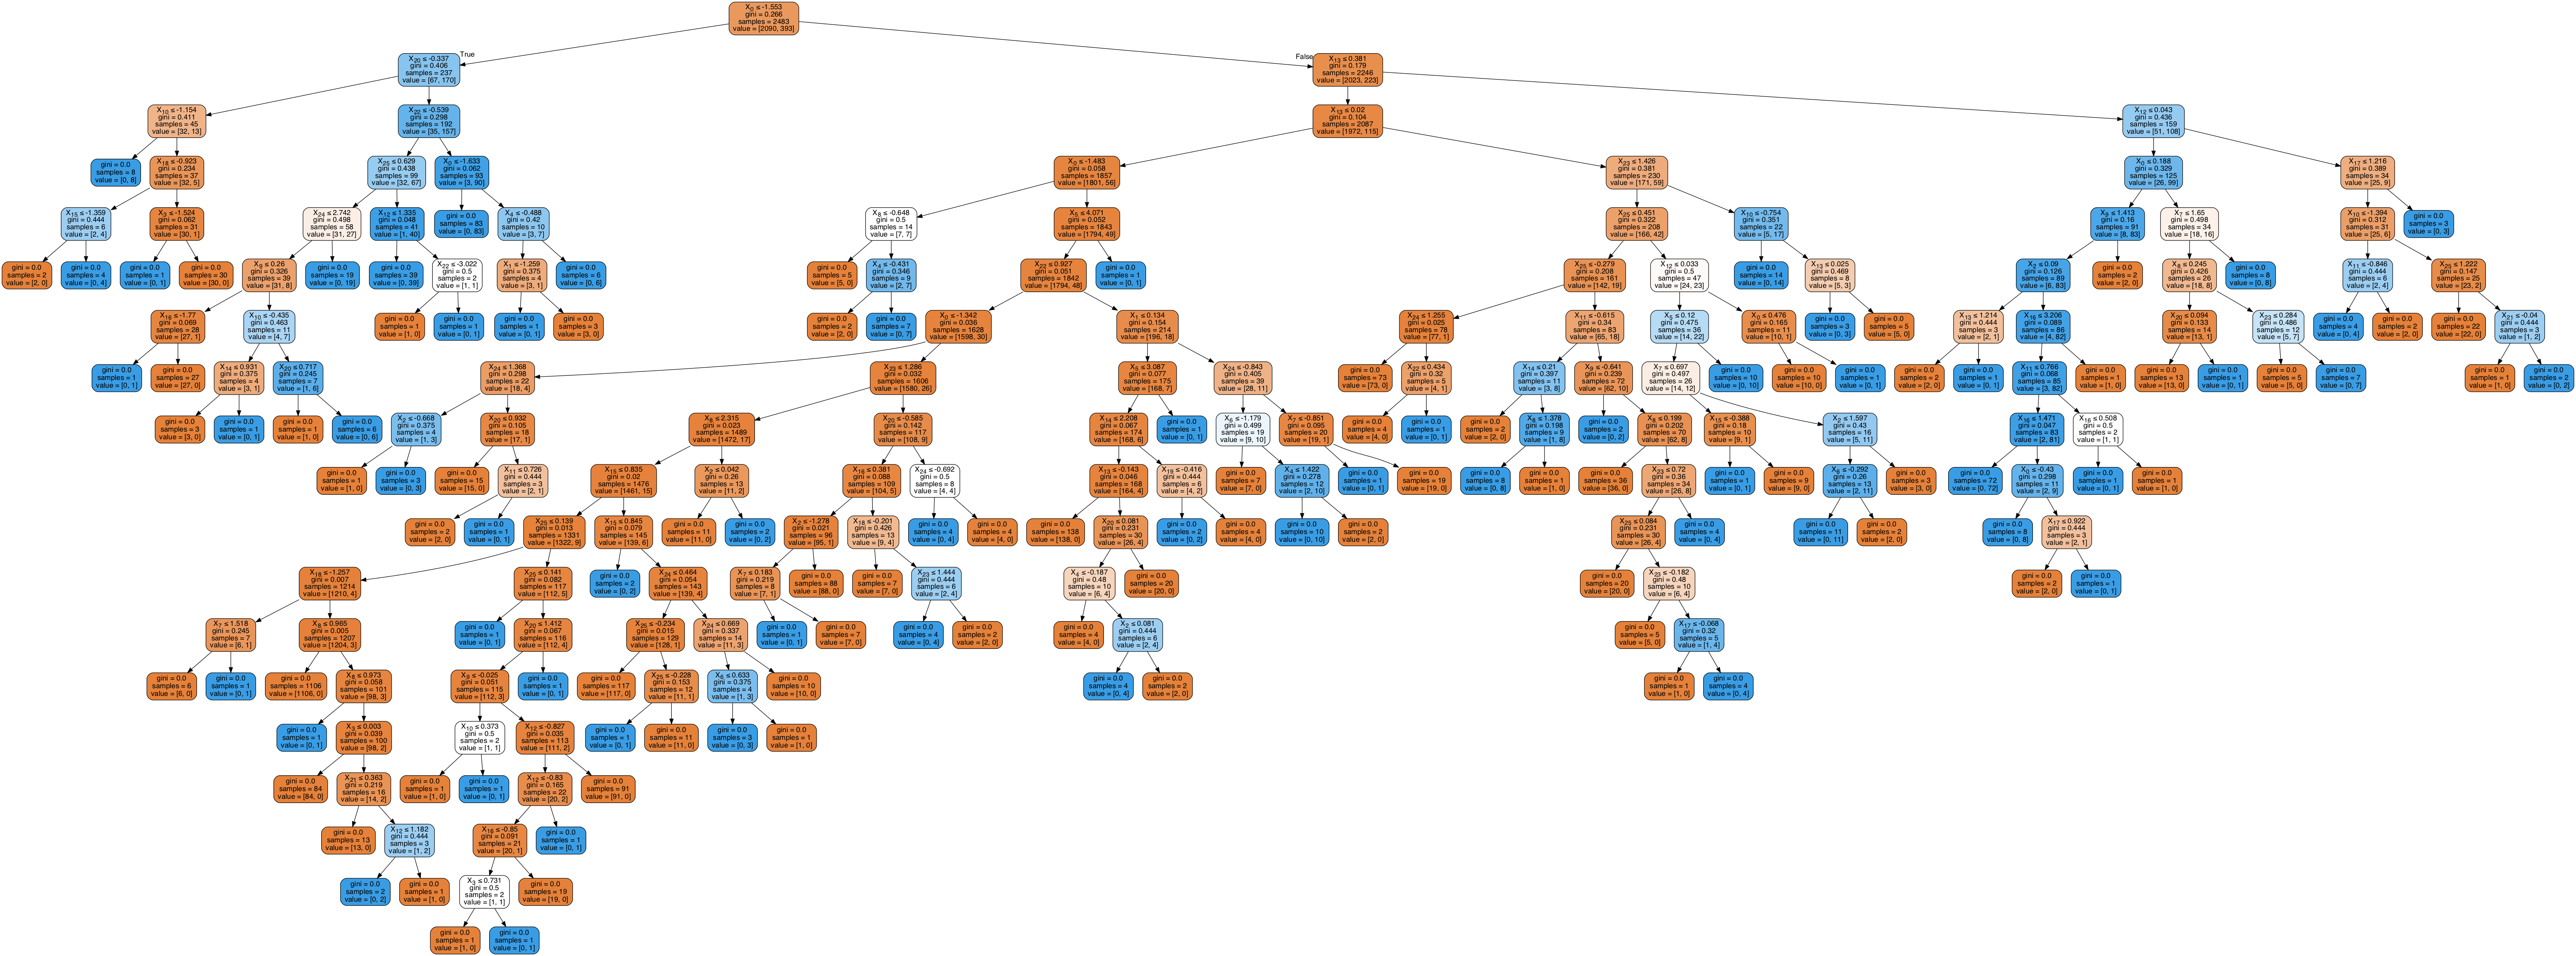

In [29]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(dtc1, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Now that I have a benchmark for the base tree, I will begin optimizing the training model. I will use the make_pipeline function so that I can normalize my data within each fold of the cross validation.

In [17]:
#use pipeline function to normalise data during each cross-validation and training decision trees. 
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(StandardScaler(), dtcm())

#inspect the parameters I can tune
pipe.get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('decisiontreeclassifier',
   DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, presort=False, random_state=None,
               splitter='best'))],
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 'standardscaler__copy': True,


I will no search for the optimal parameters for the decision tree by way of a Grid Search and 10-Fold Cross Validation. The Grid Search is computationally expensive, but will determine the optimal parameters to develop the tree. The parameters I will look to tune are 'criterion', the method used to measure impurity at each node, 'splitter', determining which featue to use to split each node, 'max_depth', which determines the maximum number of splits from the top of tree, and 'max_features', which determines how many features were sampled at each node. 

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

#creating stratified cross-validation fold indices to use during the grid search
cross_validation = StratifiedKFold(n_splits = 10, random_state = 6)

#establishing the parameter grid to test during the grid search
parameter_grid = {'decisiontreeclassifier__criterion': ['gini', 'entropy'],
                  'decisiontreeclassifier__splitter': ['best', 'random'],
                  'decisiontreeclassifier__max_depth': range(1, 15, 2),
                  'decisiontreeclassifier__max_features': range(1, 25, 2)}

#This grid search will run through every combination of the parameters given above in order to determine what the 
#optimal parameters for training the model will be, using 10-fold cross validation and averaging the accuracy
#scores to determine optimal parameters
grid_search = GridSearchCV(pipe, param_grid=parameter_grid, cv= cross_validation)

#refit the best model using the full training set, as well as visualizing the the parameters of the best model
grid_search.fit(x_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.9210632299637536
Best parameters: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__max_features': 13, 'decisiontreeclassifier__splitter': 'best'}


As seen above, the parameters for the optimal tree are 'criterion' = 'entropy', 'max_depth' = 5, 'max_features' = 13, and 'splitter' = 'best', and I will plug those in to generate the final tree. 

In [19]:
from sklearn.metrics import accuracy_score

I will now use these parameters to train the model off the entire training set, and then use this model to predict the test set that has been held out. 

In [26]:
dtc_best = dtcm(criterion = 'entropy', splitter = 'best', max_depth = 5, max_features = 13)
dtc_best.fit(x_train_n_df, y_train)

dtc_best_pred = dtc_best.predict(x_test_n_df)
accuracy_score(y_test, dtc_best_pred)

0.9146537842190016

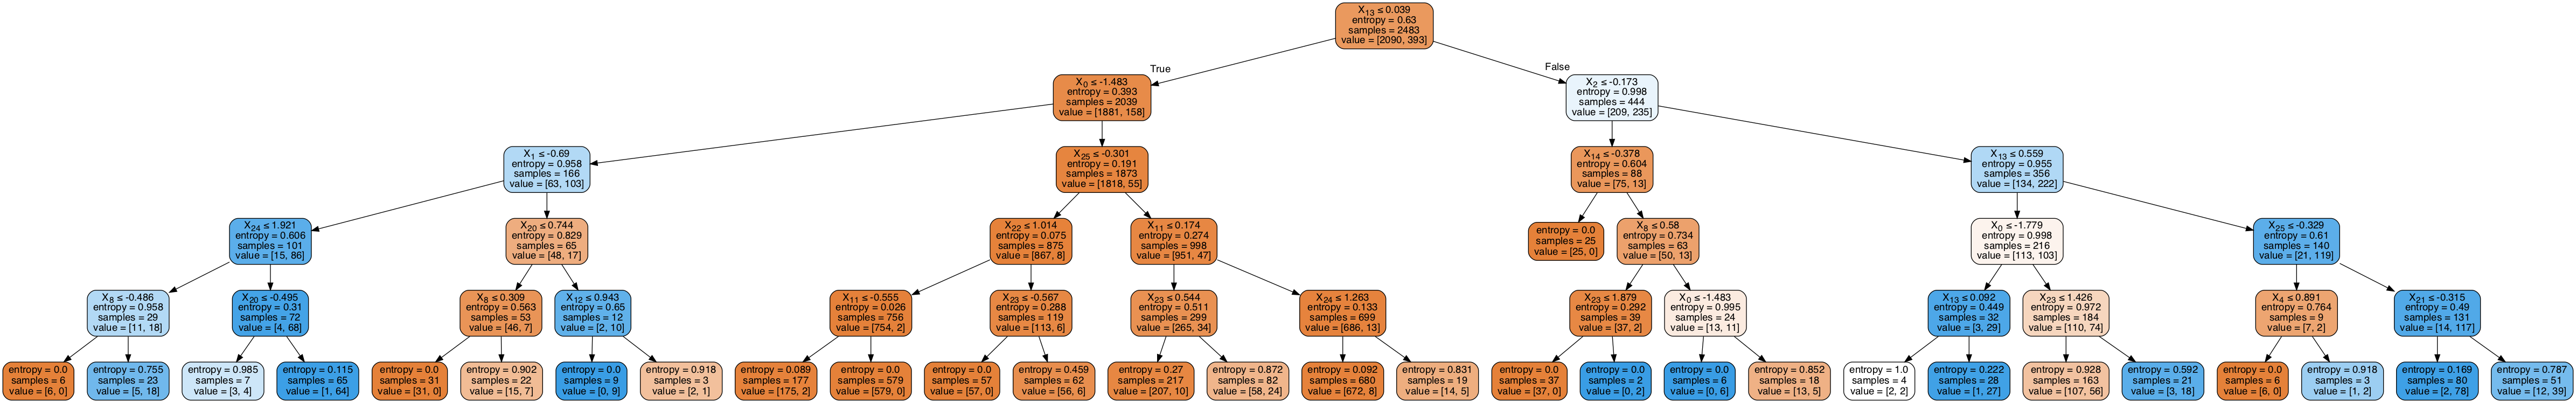

In [27]:
dot_data = StringIO()
export_graphviz(dtc_best, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# K Nearest Neighbors

In order to use KNN and Logistic Regression, I will transform the response variable from a character variable to a numeric one. This is simple in this case, as every county was either won by Hilary Clinton or Donald Trump. Thus, I will use a simple LabelEncoder to transform the categorical data into a numeric one in which 0 represents Trump and 1 represents Clinton. 

In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

y_encode = LabelEncoder().fit(y_train)

y_train_e = y_encode.transform(y_train)
y_test_e = y_encode.transform(y_test)

y_encode.classes_ #Donald Trump is 0, Hillary Clinton is 1

array(['Donald Trump', 'Hillary Clinton'], dtype=object)

In [32]:
#trains base KNN model, using an arbitrarily selected number neighbors (5)
knn1 = KNeighborsClassifier(n_neighbors = 5)
knn1.fit(x_train_n_df, y_train_e)

#tests the predictive accuracy of the base model
y_predict = knn1.predict(x_test_n_df)
acc1 = accuracy_score(y_test_e, y_predict)
acc1 

0.9452495974235104

The accuracy score of the base model is high, already 94.52%. However, I will still run parameter tuning and cross-validation to ensure the model predicts as well as it possibly could. 

In [33]:
#Creat pipeline in order to normalised data within cross-validation folds
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
#inspect the parameters I can tune
pipe_knn.get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('kneighborsclassifier',
   KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
              metric_params=None, n_jobs=None, n_neighbors=5, p=2,
              weights='uniform'))],
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'kneighborsclassifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=5, p=2,
            weights='uniform'),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__

The three parameters I will be checking are the number of neighbors, the weights being 
used, whether it will be the default uniform weight for neighbors in neighborhood or if closer neighbors will be 
weighted heavier, and lastly p, which is the power of the Minkowski metric used to measure distance. 1 corresponds 
to the Manhattan distance, and 2 corresponds to the Euclidean distance.

In [34]:
#creates a list of odd numbers of neighbors to be checked in the grid search
neighbors = [x for x in range(1, 50) if x%2 != 0]

#generates my parameter grid 
parameter_grid_knn = {'kneighborsclassifier__n_neighbors': neighbors,
                  'kneighborsclassifier__weights': ['uniform', 'distance'],
                  'kneighborsclassifier__p': [1,2],}

#This grid search will run through every combination of the parameters given above in order to determine what the 
#optimal parameters for training the model will be, using 10-fold cross validation and averaging the accuracy
#scores to determine optimal parameters
grid_search_knn = GridSearchCV(pipe_knn, param_grid=parameter_grid_knn, cv= cross_validation)

grid_search_knn.fit(x_train, y_train)
print('Best score: {}'.format(grid_search_knn.best_score_))
print('Best parameters: {}'.format(grid_search_knn.best_params_))

Best score: 0.92790978654853
Best parameters: {'kneighborsclassifier__n_neighbors': 9, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance'}


Now, I will use the optimized parameters from the grid search to generate a tuned predictive model, and test that model. To do this, I will use the parameters above and train a new model on the full normalised training set and then use that model to predict on the test set that has been held out. 

In [35]:
knn_best = KNeighborsClassifier(n_neighbors = 9, weights = 'distance', p = 1)
knn_best.fit(x_train_n_df, y_train_e)

y_predict_best = knn_best.predict(x_test_n_df)
acc2 = accuracy_score(y_test_e, y_predict_best)

acc2

0.9452495974235104

This model predicted the test set with an accuracy of 94.52% (as did the base model), but I will now look at more accuracy metrics to determine how well the model is predicting. I will first at the classification report and the confusion matrix. 

In [36]:
from sklearn.metrics import confusion_matrix, classification_report

In [37]:
print(classification_report(y_test_e, y_predict_best))
pd.DataFrame(confusion_matrix(y_test_e, y_predict_best), columns = ['Predicted Trump', 'Predicted Clinton'],
     index = ['Actual Trump', 'Actual Clinton'])

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       528
           1       0.90      0.71      0.80        93

   micro avg       0.95      0.95      0.95       621
   macro avg       0.93      0.85      0.88       621
weighted avg       0.94      0.95      0.94       621



,Predicted Trump,Predicted Clinton
Actual Trump,521,7
Actual Clinton,27,66


The key metric I looked at here is the f1-score, which is the harmonic mean of precision and recall. The f1-score is calculated by $$F_{1} = \frac{2}{\frac{1}{\text{recall}} + \frac{1}{\text{precision}}} = 2 * \frac{\text{precision} * \text{recall}}{\text{precision} + \text{recall}}$$ As this metric evaluates both precision and recall, 0.94 is an excellent $F_{1}$ score. To look further, I will examine the Precision-Recall curve. I have chosen to use the Precision-Recall curve instead of the ROC curve because as can be seen in the classification report, there is large class imbalance: far more counties in the test set voted for Trump than did Clinton. In these situations, the ROC curve can give an inflated view of the model's performance, and thus I will examine the Precision-Recall curve. 

In [38]:
from sklearn.metrics import precision_recall_curve, auc

In [39]:
#generates probabilities of being in each class
y_scores_knn = knn_best.predict_proba(x_test_n_df)

#generates precision/recall using only the probabilities of the positive class (clinton in this case) 
precision, recall, threshold = precision_recall_curve(y_test_e, y_scores_knn[:, 1])
auc_prt = auc(recall, precision)

Now I will plot the Precision-Recall Curve. This curve will plot the relationship between precision and recall at various different levels of thresholds. Ideally, the curve would be a right angle and the AUC (Area Under the Curve) would be one, but an AUC close to 1 is an excellent result. 

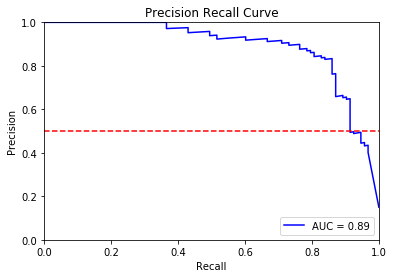

In [45]:
from matplotlib import *
import matplotlib.pyplot as plt

plt.title('Precision Recall Curve')
plt.plot(recall, precision, 'b', label = 'AUC = %0.2f' % auc_prt)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0.5, 0.5],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

The curve shows a strong model, with an AUC of 0.89. As I'd like the AUC to be as close to 1 as possible, this represents a good predictive model. 

# Logistic Regression - Base Model 

In [46]:
#train a base logistic regression model 
from sklearn.linear_model import LogisticRegression
#specifying solver as 'liblinear'
lm1 = LogisticRegression(solver = 'liblinear').fit(x_train_n_df, y_train_e)
log_predictions1 = lm1.predict(x_test_n_df)

#predict accuracy of logistic regression model
log_acc = accuracy_score(y_test_e, log_predictions1)
log_acc

0.9323671497584541

The accuracy of the base model against the test set is 93.23%, but I will again go through parameter tuning and cross validation.

In [47]:
pipe_log = make_pipeline(StandardScaler(), LogisticRegression(solver = 'liblinear'))
pipe_log.get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('logisticregression',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='warn',
             n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
             tol=0.0001, verbose=0, warm_start=False))],
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
           tol=0.0001, verbose=0, warm_start=False),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': Fals

This grid search will be evaluating the optimal value of 'C': the inverse of regularization strength as well as
the optimal penalty: 'l1' or '12'.

In [48]:
#performs grid search to determine optimal parameters for logistic regression.  
parameter_grid_log = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
                 'logisticregression__penalty': ['l1', 'l2']}

#This grid search will run through every combination of the parameters given above in order to determine what the 
#optimal parameters for training the model will be, using 10-fold cross validation and averaging the accuracy
#scores to determine optimal parameters
grid_search_log = GridSearchCV(pipe_log, param_grid=parameter_grid_log, cv= cross_validation)

grid_search_log.fit(x_train, y_train)
print('Best score: {}'.format(grid_search_log.best_score_))
print('Best parameters: {}'.format(grid_search_log.best_params_))

Best score: 0.9262988320579943
Best parameters: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}


In [49]:
log_best = LogisticRegression(solver = 'liblinear', C = 0.1, penalty = 'l2')
log_best.fit(x_train_n_df, y_train_e)

log_best_predict = log_best.predict(x_test_n_df)

log_best_acc = accuracy_score(y_test_e, log_best_predict)
log_best_acc

0.9339774557165862

With a high accuracy score of 93.39% (slightly lower than the KNN model), I will now look at the Classification Report, Confusion Matrix, and the Precision-Recall Curve. 

In [50]:
print(classification_report(y_test_e, log_best_predict))
pd.DataFrame(confusion_matrix(y_test_e, log_best_predict), columns = ['Predicted Trump', 'Predicted Clinton'],
     index = ['Actual Trump', 'Actual Clinton'])

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       528
           1       0.82      0.71      0.76        93

   micro avg       0.93      0.93      0.93       621
   macro avg       0.89      0.84      0.86       621
weighted avg       0.93      0.93      0.93       621



,Predicted Trump,Predicted Clinton
Actual Trump,514,14
Actual Clinton,27,66


The $F_1$ score for this model is strong as well (0.93) and only .01 lower than the KNN model. Now looking at the Precision-Recall Curve:

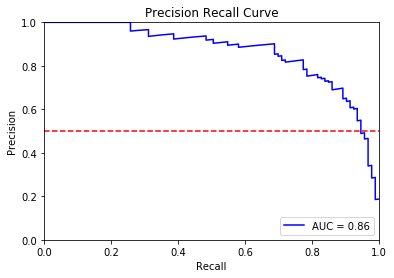

In [51]:
y_scores_log = log_best.predict_proba(x_test_n_df)
precision, recall, thresholds = precision_recall_curve(y_test_e, y_scores_log[:, 1])
auc_prt2 = auc(recall, precision)

plt.title('Precision Recall Curve')
plt.plot(recall, precision, 'b', label = 'AUC = %0.2f' % auc_prt2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0.5, 0.5],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

The Area Under the Curve is strong, 0.86. It is .03 lower than the KNN model, so at this juncture the KNN model appears to be the strongest model. However, I will not examine feature reduction to see if this can train an even superior model.

# PCA 

I will now perform Principal Component Analysis to inspect the interrelations of the independent variables and to see if reducing the number of features will better avoid overfitting and train superior models. The theory behind PCA is to perform Eigenvalue-Eigenvector decomposition on the covariance matrix of the independent variables, and then use these Eigenvalue-Eigenvector pairs to determine what percentage of the overall variance in the data is explained by each principal component. While PCA does not always guarantee a better model, it can have several benefits. In a model with many features that is prone to overfitting, dimensionality reduction can produce a better predictive model. It can also help with data has problems with linear dependence, as principal components (eigenvectors) are by definition linearly independent (orthogonal). The comination of variables comprising principal components are also weighted heavily towards the front, meaning that PC1 explains more variance than PC2 which explains more variance than PC3, etc, which makes quickly visible which principal components are not explaining much variance. 

I have chosen to perform PCA using the normalised data, as the difference in variance among the independent variables was so drastic (i.e. the standard deviation of IncomePerCap versus the standard deviation of the poverty percentage are so vastly different that normalisation is necessary to accurately assess the principal components). 

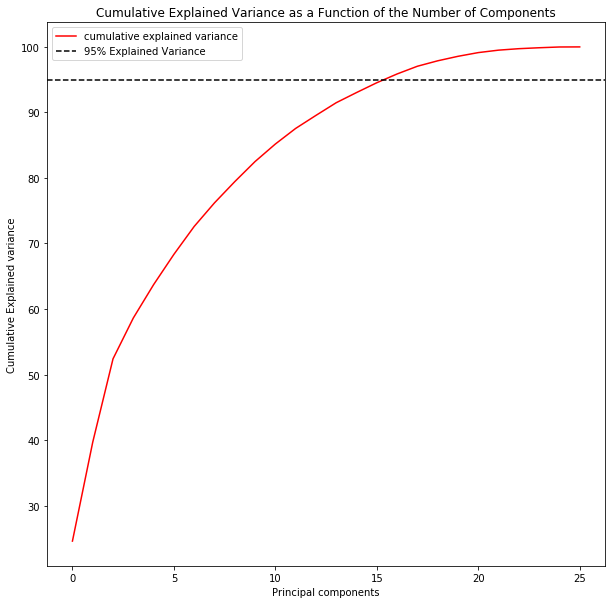

In [52]:
from sklearn.decomposition import PCA
from matplotlib.cm import register_cmap

#performs PCA, plots cumulative sum of variance explained by each principal component 
pca_n = PCA().fit(x_train_n)

cum_sum = np.cumsum(pca_n.explained_variance_ratio_)*100
d = [n for n in range(len(cum_sum))]
plt.figure(figsize=(10, 10))
plt.plot(d,cum_sum, color = 'red',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
plt.legend(loc='best')



In [53]:
#code to determine what number of components explain 95% of the variance 
total_var = 0
var_list = pca_n.explained_variance_ratio_
n = 0
pca_keep = []
while total_var <= 0.95:
    total_var += var_list[n]
    pca_keep.append(var_list[n])
    n += 1
    
len(pca_keep)

17

As can be seen from the graph and calculations above, 95% of the variance can be explained by the first 17 principal components. I will use the PCA to transform the data into with respect to the first 17 principal components, and then repeat the model building process. 

In [54]:
#generating PCA keeping only first 14 components 
pca_new = PCA(n_components = 17)
pca_new.fit(x_train_n_df)

#transforming data using first 14 components 
x_train_pca = pca_new.transform(x_train_n_df)
x_test_pca = pca_new.transform(x_test_n_df)

I will now go back through the same steps I performed above to tune the best model, but I will use the feature-reduced data set. As I have already explained all the steps I will be taking above, I will not be annotating the following code blocks. 

# Decision Tree (Feature Reduction)

In [55]:
parameter_grid_pca = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': range(1, 13, 2),
                  'max_features': range(1, 17, 2)}

grid_search_pca = GridSearchCV(dtcm(), param_grid=parameter_grid_pca, cv=cross_validation)

grid_search_pca.fit(x_train_pca, y_train)
print('Best score: {}'.format(grid_search_pca.best_score_))
print('Best parameters: {}'.format(grid_search_pca.best_params_))

dtc_pca = grid_search_pca.best_estimator_
dtc_pca

Best score: 0.896093435360451
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 13, 'splitter': 'best'}


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=13, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [56]:
dtc_pca.fit(x_train_pca, y_train)
dtc_pca_pred = dtc_pca.predict(x_test_pca)

pca_acc1 = accuracy_score(y_test, dtc_pca_pred)
pca_acc1

0.9098228663446055

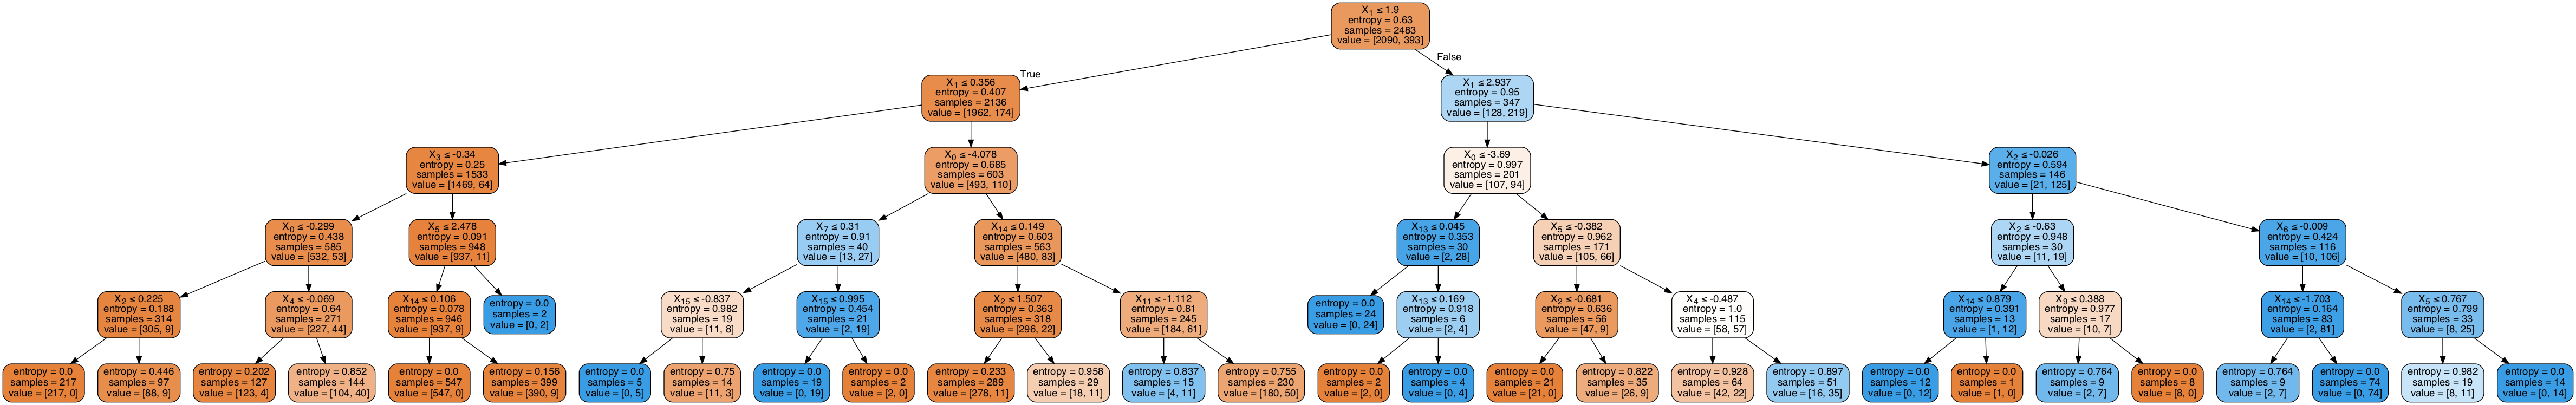

In [57]:
dot_data = StringIO()
export_graphviz(dtc_pca, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# KNN (Feature Reduction)

In [58]:
knn_pca = KNeighborsClassifier()
parameter_grid_knn_pca = {'n_neighbors': neighbors,
                  'weights': ['uniform', 'distance'],
                  'p': [1,2],}

grid_search_knn_pca = GridSearchCV(knn_pca, param_grid=parameter_grid_knn_pca, cv= cross_validation)

grid_search_knn_pca.fit(x_train, y_train)
print('Best score: {}'.format(grid_search_knn_pca.best_score_))
print('Best parameters: {}'.format(grid_search_knn_pca.best_params_))

Best score: 0.8695126862666129
Best parameters: {'n_neighbors': 29, 'p': 1, 'weights': 'uniform'}


In [59]:
knn_pca_best = KNeighborsClassifier(n_neighbors = 29, p = 1, weights = 'uniform').fit(x_train_pca, y_train_e)
knn_pca_pred = knn_pca_best.predict(x_test_pca)

accuracy_score(y_test_e, knn_pca_pred)

0.9259259259259259

In [60]:
print(classification_report(y_test_e, knn_pca_pred))
pd.DataFrame(confusion_matrix(y_test_e, knn_pca_pred), columns = ['Predicted Trump', 'Predicted Clinton'],
     index = ['Actual Trump', 'Actual Clinton'])

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       528
           1       0.93      0.55      0.69        93

   micro avg       0.93      0.93      0.93       621
   macro avg       0.93      0.77      0.82       621
weighted avg       0.93      0.93      0.92       621



,Predicted Trump,Predicted Clinton
Actual Trump,524,4
Actual Clinton,42,51


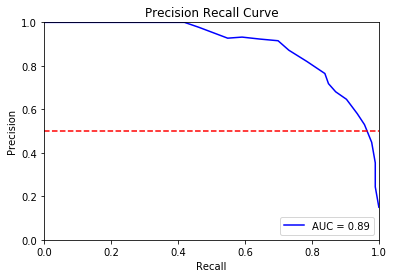

In [61]:
y_scores_knn_pca = knn_pca_best.predict_proba(x_test_pca)
precision_kpca, recall_kpca, thresholds_kpca = precision_recall_curve(y_test_e, y_scores_knn_pca[:, 1])
auc_knnpca = auc(recall_kpca, precision_kpca)

plt.title('Precision Recall Curve')
plt.plot(recall_kpca, precision_kpca, 'b', label = 'AUC = %0.2f' % auc_knnpca)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0.5, 0.5],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

# Logistic Regression (Feature Reduction)

In [62]:
log_pca = LogisticRegression(solver = 'liblinear')
parameter_grid_log_pca = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
                 'penalty': ['l1', 'l2']}

#This grid search will run through every combination of the parameters given above in order to determine what the 
#optimal parameters for training the model will be, using 10-fold cross validation and averaging the accuracy
#scores to determine optimal parameters
grid_search_log_pca = GridSearchCV(log_pca, param_grid=parameter_grid_log_pca, cv= cross_validation)

grid_search_log_pca.fit(x_train_pca, y_train_e)
print('Best score: {}'.format(grid_search_log_pca.best_score_))
print('Best parameters: {}'.format(grid_search_log_pca.best_params_))

Best score: 0.919049536850584
Best parameters: {'C': 0.1, 'penalty': 'l2'}


In [63]:
log_best_pca = LogisticRegression(solver = 'liblinear', C = 0.1, penalty = 'l2').fit(x_train_pca, y_train_e)
log_pca_pred = log_best_pca.predict(x_test_pca)

accuracy_score(y_test_e, log_pca_pred)

0.92914653784219

In [64]:
print(classification_report(y_test_e, log_pca_pred))
pd.DataFrame(confusion_matrix(y_test_e, log_pca_pred), columns = ['Predicted Trump', 'Predicted Clinton'],
     index = ['Actual Trump', 'Actual Clinton'])

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       528
           1       0.83      0.67      0.74        93

   micro avg       0.93      0.93      0.93       621
   macro avg       0.88      0.82      0.85       621
weighted avg       0.93      0.93      0.93       621



,Predicted Trump,Predicted Clinton
Actual Trump,515,13
Actual Clinton,31,62


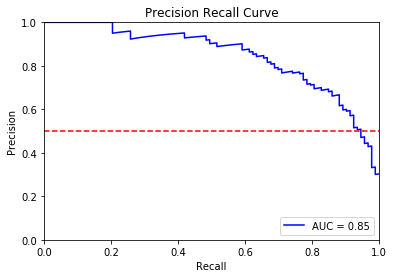

In [65]:
y_scores_log_pca = log_best_pca.predict_proba(x_test_pca)
precision_lpca, recall_lpca, thresholds_lpca = precision_recall_curve(y_test_e, y_scores_log_pca[:, 1])
auc_logpca = auc(recall_lpca, precision_lpca)

plt.title('Precision Recall Curve')
plt.plot(recall_lpca, precision_lpca, 'b', label = 'AUC = %0.2f' % auc_logpca)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0.5, 0.5],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

After training and testing three different models, the K-Nearest Neighbors model without feature reduction remains the strongest model to predict county voter behavior. With an accuracy of 94.52%, an AUC of 0.89, and an $F_{1}$ score of 0.94, it is the strongest model by every metric. 